# Evaluation der Forumtracking-Trajektorienbündel


## 1. Preprocessing

In [164]:
#imports

import numpy as np
from scipy.optimize import least_squares
from matplotlib import pyplot as plt

from sklearn.gaussian_process.kernels import RBF, Matern
import h5py

source_dataset = "../Datasets/Dataset_forumtracking.hdf5"
final_dataset = "forumtracking.hdf5"

max_trajectory_length = 100
max_nr_trajectories = 100
filter_parameter = ("", 3)

origin = "4"

%run preprocessing.py
# defines:
# filter_by_origin(path, goal, target=None)
# filter_by_length(path, length, target=None)
# filter_by_number(path, number, target=None)
# filter_trajectory(data, kind=None, windowsize=3)
# adjust_trajectory_length(trajectory, length)
# dp_algorithm(tolerance, trajectory)
# dp_cost_function(tolerance, trajectory)
# process_trajectory(trajectory, length, filter_parameter)

def get_xangle(u,deg=None):
    v = np.array([1,0])
    cosang = np.dot(u, v)
    sinang = np.linalg.norm(np.cross(u, v))
    if deg:
        return np.rad2deg(np.arctan2(sinang, cosang))
    else:
        return np.arctan2(sinang, cosang)

def rotate(points, theta):
    Phi = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    return np.matmul(Phi, points.T).T

Phi = lambda theta : np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

In [8]:
filter_by_origin(source_dataset, origin, target="forumtracking_reduced.hdf5")
filter_by_length("forumtracking_reduced.hdf5", max_trajectory_length, target=final_dataset)
#filter_by_number("forumtracking_short.hdf5", max_nr_trajectories, target=final_dataset)

os.remove("forumtracking_reduced.hdf5")
#os.remove("forumtracking_short.hdf5")
print("Done")

Done


In [9]:
i = 0
with h5py.File(final_dataset, "r") as f:
    count_total = f.attrs["TotalNrTrajectories"]
    X_forum = np.zeros((count_total, max_trajectory_length,2))
    y_forum = np.zeros((count_total,))
    for goal in f:
        for traj in f[goal]:
            trajectory = process_trajectory(f[goal+"/"+traj+"/Positions"][:], \
                                                  max_trajectory_length, \
                                                  filter_parameter)
            X_forum[i] = trajectory
            y_forum[i] = int(goal)
            i += 1

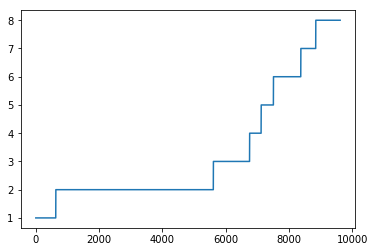

In [10]:
plt.plot(y_forum)
plt.show()

## 3.  Einzelnes Bündel nachbauen

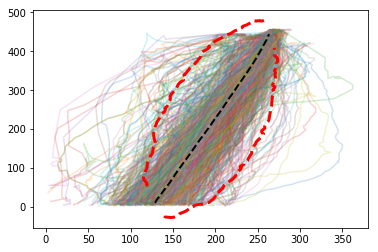

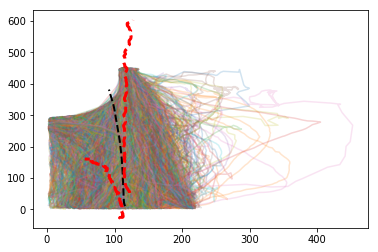

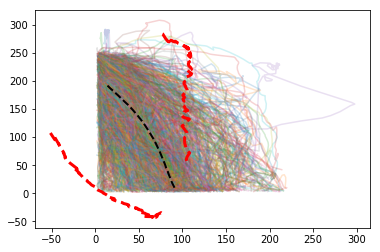

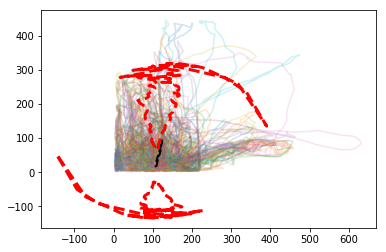

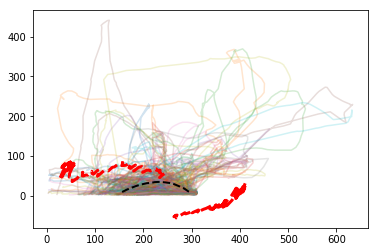

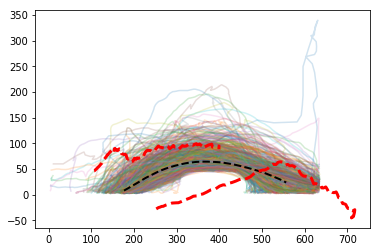

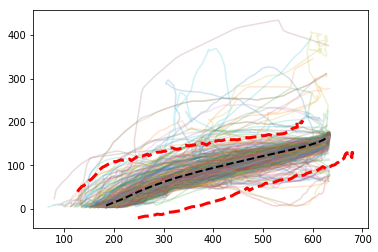

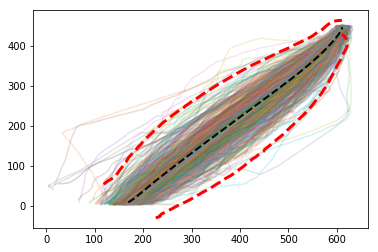

In [238]:
means = np.zeros((8,100,2))

for target in range(1,9):
    
    data = X_forum[np.where(y_forum==target)]

    for i in range(len(data)):
        plt.plot(data[i,:,0], data[i,:,1],alpha=0.2)

    mx = np.mean(data[:,:,0],axis=0)
    my = np.mean(data[:,:,1],axis=0)
    means[target-1,:,0] = mx
    means[target-1,:,1] = my
    mean = np.vstack([mx,my]).T
    
    std = np.zeros(len(mean))

    plt.plot(mx,my,linewidth=2,c="k",linestyle="--")

    Phi = lambda theta : np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])

    plt_stdx,plt_stdy = [],[]
    for i in range(1,100):
        theta = get_xangle(mean[i]-mean[i-1])
        points = data[:,i,:]- mean[i]
        rotated = rotate(points, theta)

        std[i] = np.std(rotated[:,0])

        error = np.zeros((2,2))
        error[:,0] = [-3*std[i], 3*std[i]]
        #error[:,0] = [-3*np.std(points), 3*np.std(points)]
        
        error_rot = mean[i].T + rotate(error,-1*theta)

        plt_stdx.append(error_rot.T[0])
        plt_stdy.append(error_rot.T[1])

    plt.plot(plt_stdx, plt_stdy,linewidth=3, c="r",linestyle="--")

    plt.show()

-> Nur Ziele 1,3,6,7,8 berücksichtigen

"automatische Standardabweichung" nicht immer sinnvoll, darum manuell:
    
## Ziel 1    
    
    
    

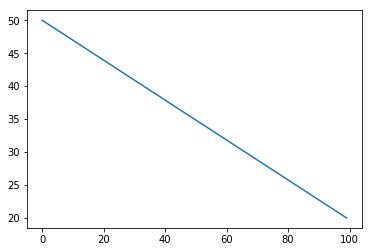

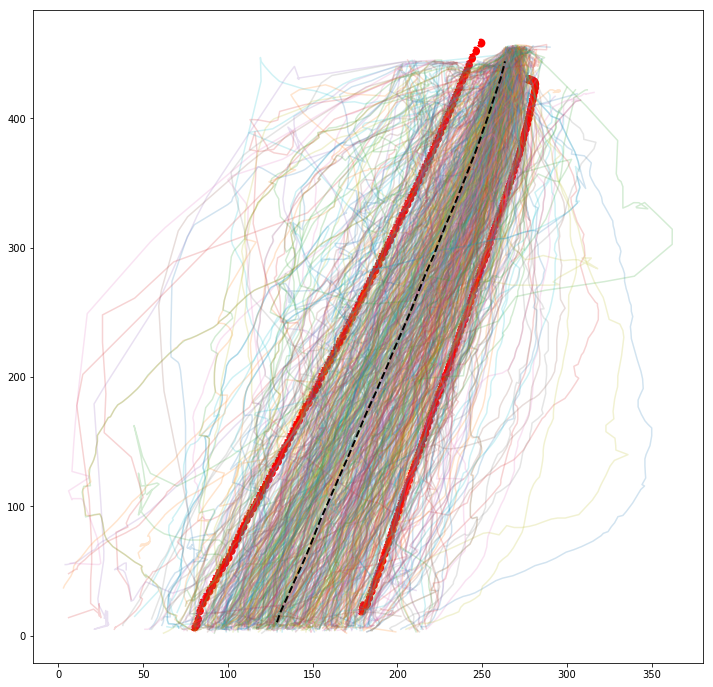

In [210]:
data = X_forum[np.where(y_forum==1)]
mean1 = means[0]

std1 = .5*(50+50*np.exp(-1*np.linspace(-2,2,max_trajectory_length)**2))
std1 = np.linspace(50,20,100)
#std1 = [50]*100

plt.plot(std1)
plt.show()

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
plt_stdx,plt_stdy = [],[]

for i in range(1,max_trajectory_length):
#for i in range(1,50):
    theta = get_xangle(mean[i]-mean[i-1])-0.25*np.pi

    std3 = np.zeros((2,2))
    std3[:,0] = [-std1[i], std1[i]]
    #error[:,0] = [-3*np.std(points), 3*np.std(points)]

    std3 = mean1[i] + rotate(std3,-1*theta)
    plt_stdx.append(std3.T[0])
    plt_stdy.append(std3.T[1])
    
    
for i in range(len(data)):
    ax.plot(data[i,:,0], data[i,:,1],alpha=0.2)

ax.plot(mean1[:,0], mean1[:,1], linewidth=2, c="k", linestyle="--")
ax.scatter(plt_stdx, plt_stdy,linewidth=3, c="r",linestyle="--")
plt.show()

## Ziel 6


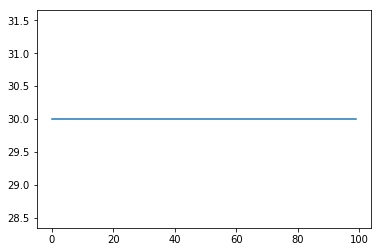

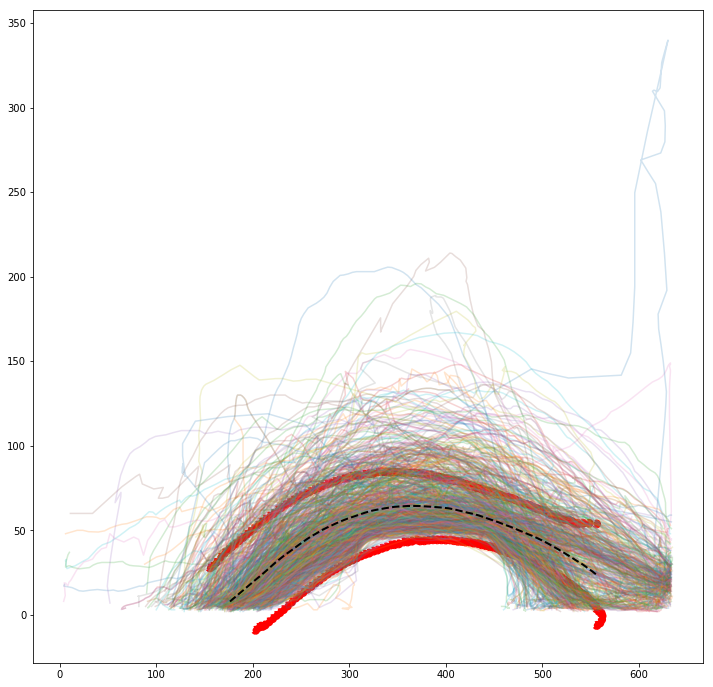

In [217]:
target = 6

data = X_forum[np.where(y_forum==target)]
mean1 = means[target-1]

std1 = .5*(50+50*np.exp(-1*np.linspace(-2,2,max_trajectory_length)**2))
std1 = np.linspace(20,40,100)
std1 = [30]*100

plt.plot(std1)
plt.show()

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
plt_stdx,plt_stdy = [],[]

for i in range(1,max_trajectory_length):
#for i in range(1,50):
    theta = get_xangle(mean[i]-mean[i-1])

    std3 = np.zeros((2,2))
    std3[:,0] = [-std1[i], std1[i]]
    #error[:,0] = [-3*np.std(points), 3*np.std(points)]

    std3 = mean1[i] + rotate(std3,-1*theta)
    plt_stdx.append(std3.T[0])
    plt_stdy.append(std3.T[1])
    
    
for i in range(len(data)):
    ax.plot(data[i,:,0], data[i,:,1],alpha=0.2)

ax.plot(mean1[:,0], mean1[:,1], linewidth=2, c="k", linestyle="--")
ax.scatter(plt_stdx, plt_stdy,linewidth=3, c="r",linestyle="--")
plt.show()

## Ziel 7

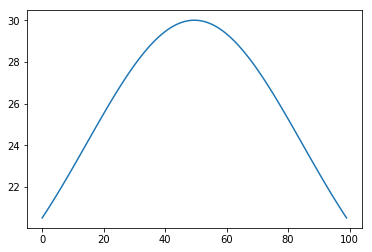

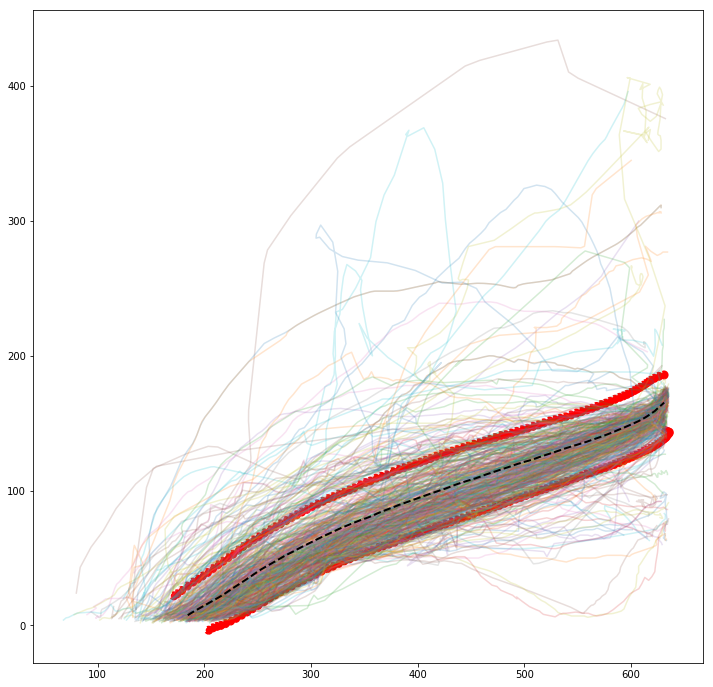

In [228]:
target = 7

data = X_forum[np.where(y_forum==target)]
mean1 = means[target-1]

std1 = .75*(20+20*np.exp(-1*np.linspace(-1,1,max_trajectory_length)**2))
#std1 = np.linspace(20,40,100)
#std1 = [30]*100

plt.plot(std1)
plt.show()

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
plt_stdx,plt_stdy = [],[]

for i in range(1,max_trajectory_length):
#for i in range(1,50):
    theta = get_xangle(mean[i]-mean[i-1])

    std3 = np.zeros((2,2))
    std3[:,0] = [-std1[i], std1[i]]
    #error[:,0] = [-3*np.std(points), 3*np.std(points)]

    std3 = mean1[i] + rotate(std3,-1*theta)
    plt_stdx.append(std3.T[0])
    plt_stdy.append(std3.T[1])
    
    
for i in range(len(data)):
    ax.plot(data[i,:,0], data[i,:,1],alpha=0.2)

ax.plot(mean1[:,0], mean1[:,1], linewidth=2, c="k", linestyle="--")
ax.scatter(plt_stdx, plt_stdy,linewidth=3, c="r",linestyle="--")
plt.show()

## Ziel 8

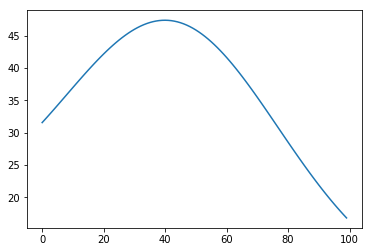

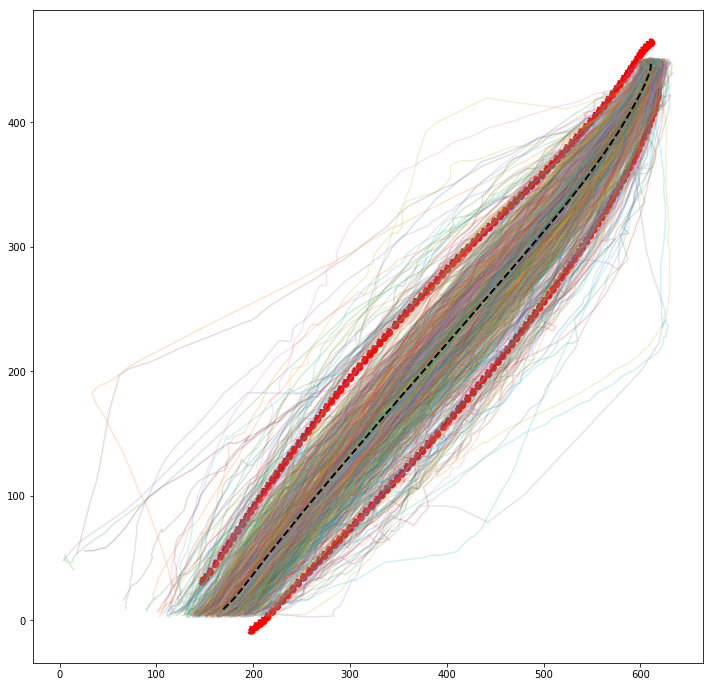

In [237]:
target = 8

data = X_forum[np.where(y_forum==target)]
mean1 = means[target-1]

std1 = 1*(10+30*np.exp(-1*np.linspace(-1,1,max_trajectory_length)**2)) * np.linspace(1.5,.8,max_trajectory_length)
#std1 = np.linspace(20,40,100)
#std1 = [30]*100

plt.plot(std1)
plt.show()

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
plt_stdx,plt_stdy = [],[]

for i in range(1,max_trajectory_length):
#for i in range(1,50):
    theta = get_xangle(mean[i]-mean[i-1])

    std3 = np.zeros((2,2))
    std3[:,0] = [-std1[i], std1[i]]
    #error[:,0] = [-3*np.std(points), 3*np.std(points)]

    std3 = mean1[i] + rotate(std3,-1*theta)
    plt_stdx.append(std3.T[0])
    plt_stdy.append(std3.T[1])
    
    
for i in range(len(data)):
    ax.plot(data[i,:,0], data[i,:,1],alpha=0.2)

ax.plot(mean1[:,0], mean1[:,1], linewidth=2, c="k", linestyle="--")
ax.scatter(plt_stdx, plt_stdy,linewidth=3, c="r",linestyle="--")
plt.show()

In [3]:
s = 2/5.
print("Hefe:  ",15*s)
print("Mehl:  ",500*s)
print("Salz:  ",10*s)
print("Oel:   ",50*s)
print("Wasser:",320*s)

Hefe:   6.0
Mehl:   200.0
Salz:   4.0
Oel:    20.0
Wasser: 128.0
